In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_filter

from galaxy_tools import load_halo, load_sim, mask_sim_to_halo, get_mock_observation
from general_tools import measure_surfbright, radius_of_param_limit
from sersic_tools import fit_sersic, sersic

%matplotlib inline
pd.set_option('display.max_columns', None)


Couldn't import numba. Missing:
abg_python.all_utils.get_cylindrical_velocities
Missing firefly, obtain it at http://github.com/ageller/Firefly or pip install firefly.


In [2]:
data = pd.read_csv('../fulldata_allparams.csv')
mock_image = np.load('../mock_image_files_round2/m11c_res2100_mockimg_xy_FOV18_p1000.npy')
band_image = np.load('../mock_image_files_round2/m11c_res2100_ugrband_xy_FOV18_p1000.npy')[1]

sim = 'm11c_res2100'
m11c = data.loc[(data['sim'] == sim) & (data['proj'] == 'xy')]


In [3]:
#z=0 for m11s
snap_num = 600
#halo file type
filetype='hdf5'


halo_path = '/data17/grenache/aalazar/FIRE/GVB/'+str(sim)+'/halo/rockstar_dm/hdf5/'
sim_path =  '/data17/grenache/aalazar/FIRE/GVB/'+str(sim)+'/output/hdf5/snapdir_'+str(snap_num)+'/'


halo = load_halo(halo_path, snap_num, host=True, filetype=filetype)
star_snapdict, gas_snapdict = load_sim(sim_path,snap_num)


In [4]:
halo['rvir'].values[0] * 0.1

16.73817596435547

In [5]:
limvalue = halo['rvir'].values[0] * 0.1 # You can play with different limit values
#limvalue = 18
FOV = limvalue
star_snapdict, gas_snapdict, halo = mask_sim_to_halo(star_snapdict=star_snapdict,
                                                     gas_snapdict=gas_snapdict, 
                                                     host_halo=halo, 
                                                     orient=False, #if true, then orients toward disk
                                                     lim = True, #Masks particles beyond limvalue  
                                                     limvalue = limvalue #limit radius in kpc
                                                    )


In [6]:
m11c

,sim,FOV,proj,pixel,tot_lum_u,tot_lum_g,tot_lum_r,r50,m50,r90,m90,r100,m100,r_3d_50,m_3d_50,r_3d_90,m_3d_90,r50_lim,m50_lim,r90_lim,m90_lim,r100_lim,m100_lim,r_3d_50_lim,m_3d_50_lim,r_3d_90_lim,m_3d_90_lim,rvir_015,rvir_015_lim,mvir_015,rvir_10,rvir_10_lim,mvir_10,rvir,rvir_lim,mvir,mbound_vir_halo,r_3d_vir015,m_3d_vir015,r_3d_vir10,m_3d_vir10,mvir_halo,Ie_1D,reff_1D,n_1D,sample_n,sample_nlessSBlim_1D,sample_nlessre_1D,r_outer_circ,r_outer_ellip,r_outer_max,Ie_1D_std,reff_1D_std,n_1D_std,Ie_2D,reff_2D,n_2D,x0_2D,y0_2D,ellip_2D,theta_2D,Ie_2D_std,reff_2D_std,n_2D_std,x0_2D_std,y0_2D_std,ellip_2D_std,theta_2D_std,Ie_1D_ellip,reff_1D_ellip,n_1D_ellip,Ie_1D_ellip_std,reff_1D_ellip_std,n_1D_ellip_std,new_pixel,sersic_lum_1Dellip,sersic_lum_1Dcircle,sersic_lum_2D,tot_mag_u,tot_mag_g,tot_mag_r,obs_mass_g,obs_mass_g_sersic
42,m11c_res2100,18,xy,1000,934345920.0,673019648.0,540359680.0,2.361355,4.776192e+08,9.059113,8.597154e+08,166.201093,9.552407e+08,3.095169,4.776193e+08,11.450474,8.597154e+08,2.259766,4.585403e+08,7.443665,8.253728e+08,16.737875,9.170812e+08,2.924495,4.500380e+08,8.74513,8.100684e+08,2.510726,2.510704,5.040888e+08,16.738176,16.737875,9.170812e+08,167.38176,166.201093,9.552407e+08,1.461396e+11,2.510721,3.753671e+08,16.73812,9.000771e+08,1.354786e+11,1.576241e+07,1.926391,0.921762,150,118,18,10.439443,12.318543,15.554771,676790.84635,0.057111,0.029111,1.539507e+07,2.184073,1.003128,0.125873,0.250407,0.284698,0.771396,30812.082062,0.002847,0.00179,0.00087,0.000862,0.000897,0.001837,1.814610e+07,2.086577,0.835498,613632.623232,0.048013,0.022559,864.0,876196535,675601256,876825429,-15.676269,-16.740069,-17.161707,6.208884e+08,8.083274e+08


### append fake guide stars 

star_snapdict['Coordinates'] = np.append(star_snapdict['Coordinates'], np.array([[5,5,0] , [0,3,0]]), axis=0)
star_snapdict['Masses'] = np.append(star_snapdict['Masses'], np.array([5000000.0,5000000.0]))
star_snapdict['Metallicity'] = np.append(star_snapdict['Metallicity'], np.array([1,1]))
star_snapdict['hsml'] = np.append(star_snapdict['hsml'], np.array([1,1]))
star_snapdict['StellarFormationTime'] = np.append(star_snapdict['StellarFormationTime'], np.array([0.92258859,0.92258859]))
star_snapdict['StellarAge'] = np.append(star_snapdict['StellarAge'], np.array([.2,.2]))
star_snapdict['r'] = np.append(star_snapdict['r'], np.array([1.13988531,1.13988531]))
star_snapdict['r_xy'] = np.append(star_snapdict['r_xy'], np.array([1.13988531,1.13988531]))
star_snapdict['r_yz'] = np.append(star_snapdict['r_yz'], np.array([1.13988531,1.13988531]))
star_snapdict['r_zx'] = np.append(star_snapdict['r_zx'], np.array([1.13988531,1.13988531]))


In [7]:
pixels = 1000 #image pixel size
FOV=limvalue
view='xy' #'yz','zx'
mock_image, uband, gband, rband = get_mock_observation(star_snapdict,gas_snapdict,
                                                       FOV=FOV, 
                                                       return_type='mock_image',
                                                       pixels=pixels,
                                                       view=view,
                                                       center='none',
                                                       minden=1e3)


Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
Projecting with attenuation...
total lum before attenuation in each band (Lsun/1e10): [0.15514164 0.09549207 0.06906826]
opacity in each band: [1585.97915621 1154.44253194  799.38644653]
total gas mass: 0.029298666267831293
maxden ==  912798.3347788377  dynrange ==  912.7983347788378  minden ==  1000.0


/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:129: RuntimeWarning: divide by zero encountered in log10
  f_i = np.log10(i/minnorm) / np.log10(maxnorm/minnorm);
/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:137: RuntimeWarning: divide by zero encountered in log
  r = np.log(r/minnorm) / np.log(maxnorm/minnorm);
/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:138: RuntimeWarning: divide by zero encountered in log
  g = np.log(g/minnorm) / np.log(maxnorm/minnorm);
/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:139: RuntimeWarning: divide by zero encountered in log
  b = np.log(b/minnorm) / np.log(maxnorm/minnorm);


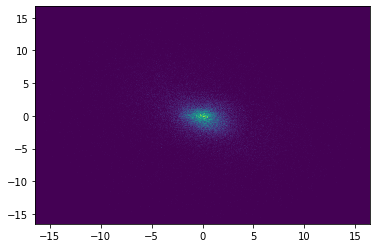

In [8]:
Mass = plt.hist2d(star_snapdict['Coordinates'][:,1],star_snapdict['Coordinates'][:,0],
                       weights=star_snapdict['Masses'], bins=pixels)

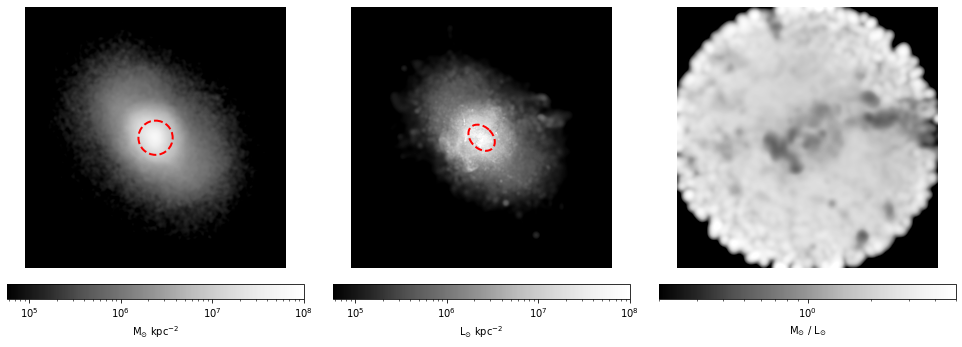

In [9]:
fig, axs = plt.subplots(1,3,figsize=(17, 6))
plt.subplots_adjust(wspace=0.1, hspace=0)

r50 = m11c['r50'].values[0]
FOV = 18
kpctopix = pixels / (FOV*2)
pixtokpc = kpctopix**-1


#-----Mass Density------
# Convert pixel values Mass/Pix2 to Mass/Kpc2
SigmaMass = Mass[0][::-1] * (pixtokpc)**-2 
# Smooth based on the median smoothing length of star particle
SigmaMass_smoothed = gaussian_filter(SigmaMass, sigma = np.median(star_snapdict['hsml'])*kpctopix )
# Mask so all pixels have values
SigmaMass_smoothed[SigmaMass_smoothed<10] = 1

Mass_image = axs[0].imshow(SigmaMass_smoothed, norm=colors.LogNorm(vmin=57650, vmax=1e8),cmap='Greys_r')


#-----Circle------
halo_lim = plt.Circle((pixels/2, pixels/2), r50 * kpctopix,  
                      color='red', fill=False, linestyle='--' ,linewidth=2)

axs[0].add_patch(halo_lim)
axs[0].axis('equal')
axs[0].axis('off')

#-----Labels------
scale_kpc = FOV / 4
scale_kpc = int(np.ceil(scale_kpc))
locx_kpc = -15
locy_kpc = -15
locy_kpc_label = -14

#axs[0].plot([locx_kpc ,locx_kpc  + scale_kpc],[locy_kpc,locy_kpc],  c='w', linewidth='5')
#axs[0].text(locx_kpc, locy_kpc_label, f'{scale_kpc:.0f} kpc',color='white', fontsize=20)
#axs[0].text(locy_kpc, 15, f'a)',color='white', fontsize=20)

cb = fig.colorbar(Mass_image, ax=axs[0],  orientation="horizontal", pad=0.05)
cb.set_label(r'M$_{\odot}$ kpc$^{-2}$')


#-----Image------
plt.subplots_adjust(wspace=0.1, hspace=0)

gband[gband<10] = 10

image = axs[1].imshow(gband ,norm=colors.LogNorm(vmin=57650, vmax=1e8),
                      cmap='Greys_r')


#-----Labels------
pixel_bar = scale_kpc * 500 / FOV
pixel_bar = int(np.ceil(pixel_bar))

kpctopix = 500 / FOV
locx_pix = np.abs(locx_kpc) * kpctopix + 500
locy_pix = 500 - np.abs(locy_kpc)* kpctopix
locy_pix_label = np.abs(locy_kpc_label) * kpctopix + 500
#axs[1].plot([locy_pix,locy_pix + pixel_bar],[locx_pix,locx_pix],  c='w', linewidth='5')
#axs[1].text(locy_pix, locy_pix, f'b)',color='white', fontsize=20)
#axs[1].text(locy_pix, locy_pix_label, f'{scale_kpc:.0f} kpc',color='white', fontsize=20)
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
axs[1].axis('equal')
axs[1].axis('off')

cb = fig.colorbar(image, ax=axs[1], orientation="horizontal", pad=0.05)
cb.set_label(r'L$_{\odot}$ kpc$^{-2}$')

#-----Ellipse------
ellip = m11c['ellip_2D'].values[0]
theta = m11c['theta_2D'].values[0]
reff_1D_ellip =m11c['reff_1D_ellip'].values[0]

major = reff_1D_ellip
minor = reff_1D_ellip * (1 - ellip)

ellipse = Ellipse((500, 500), major * kpctopix * 2, minor * kpctopix * 2, angle=theta*180/np.pi, 
                  alpha=1,  color='red', fill=False, linestyle='--' ,linewidth=2)
axs[1].add_patch(ellipse)


#-----Mass-to-Light-Ratio------
plt.subplots_adjust(wspace=0.1, hspace=0)
smooth = 10
Mass_to_Light_ratio = gaussian_filter(SigmaMass_smoothed, sigma = smooth)/gaussian_filter(gband, sigma = smooth)

MLR = axs[2].imshow((Mass_to_Light_ratio), cmap='Greys_r', norm=colors.LogNorm(vmin=2e-1, vmax=5e0))
                    #norm=colors.Normalize(vmin=0.2, vmax=5))

axs[2].axis('equal')
axs[2].axis('off')

cb = fig.colorbar(MLR, ax=axs[2], orientation="horizontal", pad=0.05)
cb.set_label(r'M$_{\odot}$ / L$_{\odot}$')

#plt.savefig('plots/partice_mockimg_w_measure.pdf', bbox_inches='tight', dpi=300)

plt.show()



In [10]:
band_image = np.load('../mock_image_files_round2/m11c_res2100_ugrband_xy_FOV18_p1000.npy')[1]


In [11]:
sim_data = m11c

In [12]:
sim_data['r100']/sim_data['r100_lim']

42    9.929641
dtype: float64

In [13]:
sim_data['r90']/sim_data['r90_lim']

42    1.217023
dtype: float64

In [14]:
sim_data 

,sim,FOV,proj,pixel,tot_lum_u,tot_lum_g,tot_lum_r,r50,m50,r90,m90,r100,m100,r_3d_50,m_3d_50,r_3d_90,m_3d_90,r50_lim,m50_lim,r90_lim,m90_lim,r100_lim,m100_lim,r_3d_50_lim,m_3d_50_lim,r_3d_90_lim,m_3d_90_lim,rvir_015,rvir_015_lim,mvir_015,rvir_10,rvir_10_lim,mvir_10,rvir,rvir_lim,mvir,mbound_vir_halo,r_3d_vir015,m_3d_vir015,r_3d_vir10,m_3d_vir10,mvir_halo,Ie_1D,reff_1D,n_1D,sample_n,sample_nlessSBlim_1D,sample_nlessre_1D,r_outer_circ,r_outer_ellip,r_outer_max,Ie_1D_std,reff_1D_std,n_1D_std,Ie_2D,reff_2D,n_2D,x0_2D,y0_2D,ellip_2D,theta_2D,Ie_2D_std,reff_2D_std,n_2D_std,x0_2D_std,y0_2D_std,ellip_2D_std,theta_2D_std,Ie_1D_ellip,reff_1D_ellip,n_1D_ellip,Ie_1D_ellip_std,reff_1D_ellip_std,n_1D_ellip_std,new_pixel,sersic_lum_1Dellip,sersic_lum_1Dcircle,sersic_lum_2D,tot_mag_u,tot_mag_g,tot_mag_r,obs_mass_g,obs_mass_g_sersic
42,m11c_res2100,18,xy,1000,934345920.0,673019648.0,540359680.0,2.361355,4.776192e+08,9.059113,8.597154e+08,166.201093,9.552407e+08,3.095169,4.776193e+08,11.450474,8.597154e+08,2.259766,4.585403e+08,7.443665,8.253728e+08,16.737875,9.170812e+08,2.924495,4.500380e+08,8.74513,8.100684e+08,2.510726,2.510704,5.040888e+08,16.738176,16.737875,9.170812e+08,167.38176,166.201093,9.552407e+08,1.461396e+11,2.510721,3.753671e+08,16.73812,9.000771e+08,1.354786e+11,1.576241e+07,1.926391,0.921762,150,118,18,10.439443,12.318543,15.554771,676790.84635,0.057111,0.029111,1.539507e+07,2.184073,1.003128,0.125873,0.250407,0.284698,0.771396,30812.082062,0.002847,0.00179,0.00087,0.000862,0.000897,0.001837,1.814610e+07,2.086577,0.835498,613632.623232,0.048013,0.022559,864.0,876196535,675601256,876825429,-15.676269,-16.740069,-17.161707,6.208884e+08,8.083274e+08


Look into the mass to light ratio

Look at mass & light within 50, 90, 100, and between 50-90, 90-100


In [15]:
sim_data['r50_lim'].values[0]

2.25976556639467

In [16]:
r_m50, r_m90, r_m100 = [sim_data['r50_lim'].values[0],
                        sim_data['r90_lim'].values[0],
                        sim_data['r100_lim'].values[0]]
m50, m90, m100 = [sim_data['m50_lim'].values[0],
                  sim_data['m90_lim'].values[0],
                  sim_data['m100_lim'].values[0]]


In [17]:
# open image
# start with circular symmetry

r_light, cum_light = measure_surfbright(gband, FOV=FOV, nmeasure=100,sb_lim=0,return_type='cum_lum')


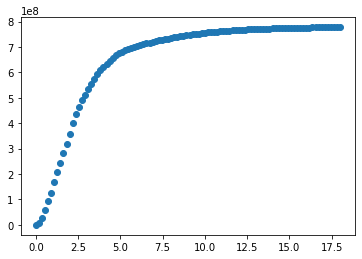

In [18]:
plt.scatter(r_light, cum_light)

In [22]:
r_l,light = radius_of_param_limit(r_light, cum_light, cumulative=True,
                                  limits = [r_m50, r_m90, r_m100], 
                                  limit_type='radius')



In [23]:
light

[400348256.0, 725530816.0, 776929920.0]

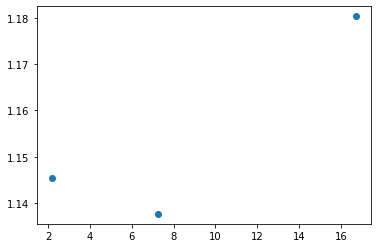

In [24]:
plt.scatter(r_l,[m50/light[0], m90/light[1], m100/light[2]] )

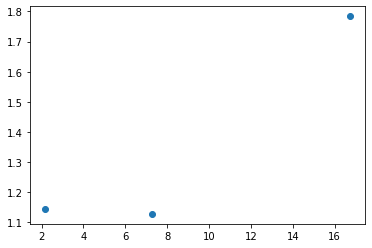

In [25]:
plt.scatter(r_l,[m50/light[0], (m90-m50)/(light[1]-light[0]), (m100-m90)/(light[2]-light[1])] )

In [ ]:
r_m50, r_m90, r_m100

In [169]:
np.log10(light)

array([ 9.36047388, 10.30405473, 10.77650801])

In [170]:
np.log10([m50,m90,m100])

array([8.66137749, 8.91665018, 8.96240778])

In [ ]:
simdata['r50'] 
simdata['r90'] 
simdata['r100'] 


In [112]:
data

,sim,FOV,proj,pixel,tot_lum_u,tot_lum_g,tot_lum_r,r50,m50,r90,m90,r100,m100,r_3d_50,m_3d_50,r_3d_90,m_3d_90,r50_lim,m50_lim,r90_lim,m90_lim,r100_lim,m100_lim,r_3d_50_lim,m_3d_50_lim,r_3d_90_lim,m_3d_90_lim,rvir_015,rvir_015_lim,mvir_015,rvir_10,rvir_10_lim,mvir_10,rvir,rvir_lim,mvir,mbound_vir_halo,r_3d_vir015,m_3d_vir015,r_3d_vir10,m_3d_vir10,mvir_halo,Ie_1D,reff_1D,n_1D,sample_n,sample_nlessSBlim_1D,sample_nlessre_1D,r_outer_circ,r_outer_ellip,r_outer_max,Ie_1D_std,reff_1D_std,n_1D_std,Ie_2D,reff_2D,n_2D,x0_2D,y0_2D,ellip_2D,theta_2D,Ie_2D_std,reff_2D_std,n_2D_std,x0_2D_std,y0_2D_std,ellip_2D_std,theta_2D_std,Ie_1D_ellip,reff_1D_ellip,n_1D_ellip,Ie_1D_ellip_std,reff_1D_ellip_std,n_1D_ellip_std,new_pixel,sersic_lum_1Dellip,sersic_lum_1Dcircle,sersic_lum_2D,tot_mag_u,tot_mag_g,tot_mag_r,obs_mass_g,obs_mass_g_sersic
0,m10b_res500,3,xy,1000,3.149110e+06,1.204539e+06,6.689034e+05,0.236215,2.359851e+05,0.667788,4.245811e+05,14.270773,4.719756e+05,0.349845,2.359324e+05,0.932531,4.244896e+05,0.233507,2.330390e+05,0.625410,4.193105e+05,5.279339,4.661921e+05,0.345265,2.321113e+05,0.885183,4.181071e+05,0.814818,0.812143,4.411729e+05,5.432121,5.279339,4.661921e+05,54.321208,14.270773,4.719756e+05,9.060563e+09,0.814178,4.069832e+05,4.999770,4.648137e+05,9.060563e+09,2.449505e+06,0.222618,0.187862,100,81,27,0.596248,0.661590,0.808610,6.846107e+04,0.016833,0.015954,3.740332e+06,0.158063,0.951401,0.237137,-0.068885,1.826353e-01,2.895685,1.778896e+04,0.000490,0.004231,0.000185,0.000155,0.002512,0.007568,2.774345e+06,0.146584,0.164475,6.062622e+04,0.291242,0.012228,268.0,1305786,1107607,1082498,-9.495469,-9.872052,-9.893409,2.166242e+05,2.348324e+05
1,m10b_res500,3,yz,1000,3.148890e+06,1.201734e+06,6.672877e+05,0.304723,2.356667e+05,0.874010,4.245044e+05,46.409061,4.719756e+05,0.349845,2.359324e+05,0.932531,4.244896e+05,0.300704,2.324563e+05,0.828304,4.185837e+05,4.975017,4.651677e+05,0.345265,2.321113e+05,0.885183,4.181071e+05,0.814818,0.814501,4.164895e+05,5.432121,4.975017,4.651677e+05,54.321208,46.409061,4.719756e+05,9.060563e+09,0.814178,4.069832e+05,4.999770,4.648137e+05,9.060563e+09,5.663015e+06,0.139698,0.594589,100,88,21,0.550772,0.576999,0.649124,2.769531e+05,0.004331,0.031502,5.608945e+06,0.139732,0.771942,0.052970,0.020395,9.592509e-02,2.798160,9.950443e+03,0.000163,0.001545,0.000083,0.000077,0.001166,0.006386,5.519332e+06,0.148685,0.621937,1.684221e+05,0.002907,0.019708,216.0,1204829,1074080,1173759,-9.495394,-9.869521,-9.890783,2.160365e+05,2.165929e+05
2,m10b_res500,3,zx,1000,3.173906e+06,1.208519e+06,6.698021e+05,0.289048,2.357400e+05,0.850310,4.246346e+05,45.514264,4.719756e+05,0.349845,2.359324e+05,0.932531,4.244896e+05,0.285622,2.324678e+05,0.758779,4.183666e+05,4.780156,4.651776e+05,0.345265,2.321113e+05,0.885183,4.181071e+05,0.814818,0.810658,4.213099e+05,5.432121,4.780156,4.651776e+05,54.321208,45.514264,4.719756e+05,9.060563e+09,0.814178,4.069832e+05,4.999770,4.648137e+05,9.060563e+09,2.639339e+06,0.065969,0.163511,250,178,17,0.595670,0.627021,0.867379,5.139850e+04,6.822209,0.007202,3.805218e+06,0.153223,0.956109,-0.013153,-0.239321,1.333295e-01,1.621786,1.742570e+04,0.000458,0.004078,0.000150,0.000173,0.002558,0.010278,2.799068e+06,0.061736,0.163506,4.400857e+04,4.067436,0.002455,288.0,1212090,1063888,1038683,-9.503985,-9.875633,-9.894866,2.154629e+05,2.160997e+05
3,m10c_res500,3,xy,1000,1.269095e+06,8.320198e+05,5.549361e+05,0.241338,2.893847e+05,0.725035,5.212976e+05,13.042940,5.793567e+05,0.349568,2.893690e+05,1.073333,5.213609e+05,0.241284,2.890193e+05,0.721698,5.202140e+05,5.329707,5.783448e+05,0.346277,2.865299e+05,1.040137,5.158477e+05,0.803589,0.800305,5.255868e+05,5.357262,5.329707,5.783448e+05,53.572620,13.042940,5.793567e+05,8.690141e+09,0.798282,4.905529e+05,4.440888,5.733660e+05,8.694366e+09,2.655395e+06,0.148385,0.698861,100,87,15,0.625920,0.812761,0.924866,3.133577e+05,0.011460,0.077844,1.686288e+06,0.243635,1.147652,0.026351,0.007586,4.098384e-01,2.317822,4.920568e+03,0.000462,0.002642,0.000101,0.000105

In [125]:
data['m100_lim'][:5]/data['m100'][:5]

0    0.987746
1    0.985576
2    0.985597
3    0.998253
4    0.990983
dtype: float64

In [126]:
data['m100_lim'][:5]/data['obs_mass_g'][:5]

0    2.152078
1    2.153190
2    2.158968
3    1.715096
4    1.700527
dtype: float64

In [127]:
data['m100'][:5]/data['obs_mass_g'][:5]

0    2.178776
1    2.184703
2    2.190519
3    1.718097
4    1.716000
dtype: float64

In [115]:
data['m100_lim'][:5]

0    466192.120959
1    465167.654769
2    465177.616798
3    578344.751638
4    574132.690174
Name: m100_lim, dtype: float64

In [120]:
data['mvir_10'][:5]/data['m100'][:5]

0    0.987746
1    0.985576
2    0.985597
3    0.998253
4    0.990983
dtype: float64

In [119]:
data['m100'][:5]

0    471975.632073
1    471975.632073
2    471975.632073
3    579356.711196
4    579356.711196
Name: m100, dtype: float64

In [118]:
data['rvir_10'][:5]

0    5.432121
1    5.432121
2    5.432121
3    5.357262
4    5.357262
Name: rvir_10, dtype: float64

In [117]:
data['r100_lim'][:5]

0    5.279339
1    4.975017
2    4.780156
3    5.329707
4    5.346173
Name: r100_lim, dtype: float64

In [77]:
params2D = [m11c['Ie_2D'].values[0],
            m11c['reff_2D'].values[0],
            m11c['n_2D'].values[0],
            m11c['x0_2D'].values[0],
            m11c['y0_2D'].values[0],
            m11c['ellip_2D'].values[0],
            m11c['theta_2D'].values[0]
           ]
params2D

[15395072.20532002,
 2.1840731033133336,
 1.00312813126167,
 0.1258730531469459,
 0.2504073508713931,
 0.2846980552326728,
 0.7713962351498225]

In [78]:
r_mass,sb_mass = measure_surfbright(SigmaMass, FOV=FOV, nmeasure=50,sb_lim=0,
                          major_axis=params2D[1], ellip=params2D[5], theta=params2D[6])
popt_mass,std_mass= fit_sersic(r_mass, sb_mass)

r_light,sb_light = measure_surfbright(gband, FOV=FOV, nmeasure=50,sb_lim=0,
                          major_axis=params2D[1], ellip=params2D[5], theta=params2D[6])
popt_light,std_light = fit_sersic(r_light, sb_light)

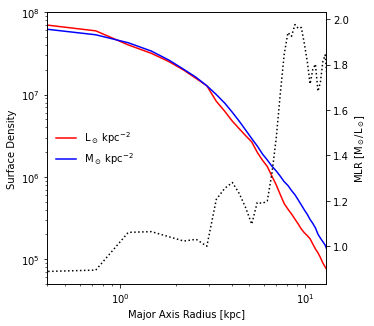

In [104]:
r_mass,sb_mass = measure_surfbright(SigmaMass, FOV=FOV, nmeasure=50,sb_lim=0,
                          major_axis=params2D[1], ellip=params2D[5], theta=params2D[6])
popt_mass,std_mass= fit_sersic(r_mass, sb_mass)

r_light,sb_light = measure_surfbright(gband, FOV=FOV, nmeasure=50,sb_lim=0,
                          major_axis=params2D[1], ellip=params2D[5], theta=params2D[6])
popt_light,std_light = fit_sersic(r_light, sb_light)



fig, ax1 = plt.subplots(figsize=(5, 5))

ax1.loglog(r_light, sb_light,label='L$_\odot$ kpc$^{-2}$',c='red')
ax1.set_xlabel("Major Axis Radius [kpc]")

ax1.loglog(r_mass,  sb_mass ,label='M$_\odot$ kpc$^{-2}$',c='blue')
ax1.set_ylabel("Surface Density")
plt.legend(loc=6,frameon=False)

ax1.set_ylim(5e4,1e8)
ax1.set_xlim(4e-1,1.3e1)

ax2 = ax1.twinx() 
ax2.plot(r_mass, sb_mass/sb_light, label='MtoL', c='k', linestyle=':')
ax2.set_ylabel("MLR [M$_\odot$/L$_\odot$]")


plt.show()

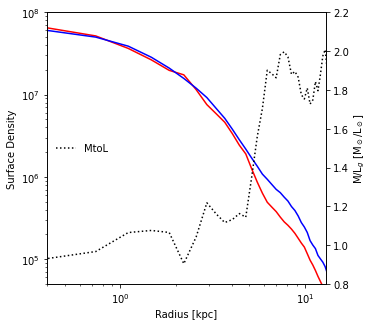

In [101]:
r_mass,sb_mass = measure_surfbright(SigmaMass, FOV=FOV, nmeasure=50,sb_lim=0)
popt_mass,std_mass= fit_sersic(r_mass, sb_mass)

r_light,sb_light = measure_surfbright(gband, FOV=FOV, nmeasure=50,sb_lim=0)
popt_light,std_light = fit_sersic(r_light, sb_light)


fig, ax1 = plt.subplots(figsize=(5, 5))

ax1.loglog(r_light, sb_light,label='L$_\odot$ kpc$^{-2}$',c='red')
ax1.set_xlabel("Radius [kpc]")

ax1.loglog(r_mass,  sb_mass ,label='M$_\odot$ kpc$^{-2}$',c='blue')
ax1.set_ylabel("Surface Density")

ax1.set_ylim(5e4,1e8)
ax1.set_xlim(4e-1,1.3e1)


ax2 = ax1.twinx() 
ax2.plot(r_mass,  sb_mass/sb_light ,label='MtoL',c='k',linestyle=':')
ax2.set_ylabel("M/L$_g$ [M$_\odot$/L$_\odot$]")
ax2.set_ylim(.8,2.2)
plt.legend(loc=6,frameon=False)
plt.show()

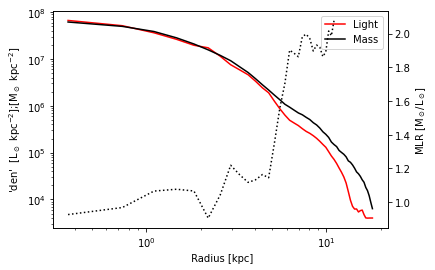

In [68]:
r_mass,sb_mass = measure_surfbright(SigmaMass, FOV=FOV, nmeasure=50,sb_lim=0)
popt_mass,std_mass= fit_sersic(r_mass, sb_mass)

r_light,sb_light = measure_surfbright(gband, FOV=FOV, nmeasure=50,sb_lim=0)
popt_light,std_light = fit_sersic(r_light, sb_light)


fig, ax1 = plt.subplots()

ax1.loglog(r_light, sb_light,label='Light',c='red')
ax1.set_xlabel(" Radius [kpc]")

ax1.loglog(r_mass,  sb_mass ,label='Mass',c='k')
ax1.set_ylabel("'den'  [L$_\odot$ kpc$^{-2}$];[M$_\odot$ kpc$^{-2}$]")
plt.legend()

ax2 = ax1.twinx() 
ax2.plot(r_mass[:30],  sb_mass[:30]/sb_light[:30] ,label='MtoL',c='k',linestyle=':')
ax2.set_ylabel("MLR [M$_\odot$/L$_\odot$]")


plt.show()

In [22]:
r_mass,sb_mass = measure_surfbright(SigmaMass, FOV=FOV, nmeasure=50,sb_lim=0,return_type='cum_lum')

r_light,sb_light = measure_surfbright(gband, FOV=FOV, nmeasure=50,sb_lim=0,return_type='cum_lum')

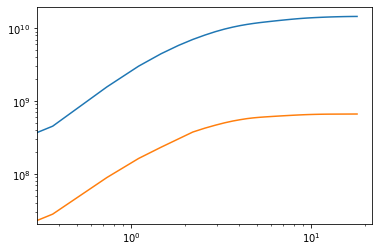

In [26]:
plt.loglog(r_mass,sb_mass)
plt.loglog(r_light,sb_light)

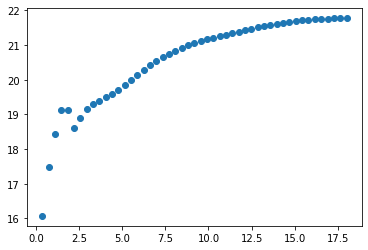

In [30]:
plt.scatter(r_mass[1:],sb_mass[1:]/sb_light[1:])

In [34]:
m11c

,sim,FOV,proj,pixel,tot_lum_u,tot_lum_g,tot_lum_r,r50,m50,r90,m90,r100,m100,r_3d_50,m_3d_50,r_3d_90,m_3d_90,r50_lim,m50_lim,r90_lim,m90_lim,r100_lim,m100_lim,r_3d_50_lim,m_3d_50_lim,r_3d_90_lim,m_3d_90_lim,rvir_015,rvir_015_lim,mvir_015,rvir_10,rvir_10_lim,mvir_10,rvir,rvir_lim,mvir,mbound_vir_halo,r_3d_vir015,m_3d_vir015,r_3d_vir10,m_3d_vir10,mvir_halo,Ie_1D,reff_1D,n_1D,sample_n,sample_nlessSBlim_1D,sample_nlessre_1D,r_outer_circ,r_outer_ellip,r_outer_max,Ie_1D_std,reff_1D_std,n_1D_std,Ie_2D,reff_2D,n_2D,x0_2D,y0_2D,ellip_2D,theta_2D,Ie_2D_std,reff_2D_std,n_2D_std,x0_2D_std,y0_2D_std,ellip_2D_std,theta_2D_std,Ie_1D_ellip,reff_1D_ellip,n_1D_ellip,Ie_1D_ellip_std,reff_1D_ellip_std,n_1D_ellip_std,new_pixel,sersic_lum_1Dellip,sersic_lum_1Dcircle,sersic_lum_2D,tot_mag_u,tot_mag_g,tot_mag_r,obs_mass_g,obs_mass_g_sersic
42,m11c_res2100,18,xy,1000,934345920.0,673019648.0,540359680.0,2.361355,4.776192e+08,9.059113,8.597154e+08,166.201093,9.552407e+08,3.095169,4.776193e+08,11.450474,8.597154e+08,2.259766,4.585403e+08,7.443665,8.253728e+08,16.737875,9.170812e+08,2.924495,4.500380e+08,8.74513,8.100684e+08,2.510726,2.510704,5.040888e+08,16.738176,16.737875,9.170812e+08,167.38176,166.201093,9.552407e+08,1.461396e+11,2.510721,3.753671e+08,16.73812,9.000771e+08,1.354786e+11,1.576241e+07,1.926391,0.921762,150,118,18,10.439443,12.318543,15.554771,676790.84635,0.057111,0.029111,1.539507e+07,2.184073,1.003128,0.125873,0.250407,0.284698,0.771396,30812.082062,0.002847,0.00179,0.00087,0.000862,0.000897,0.001837,1.814610e+07,2.086577,0.835498,613632.623232,0.048013,0.022559,864.0,876196535,675601256,876825429,-15.676269,-16.740069,-17.161707,6.208884e+08,8.083274e+08


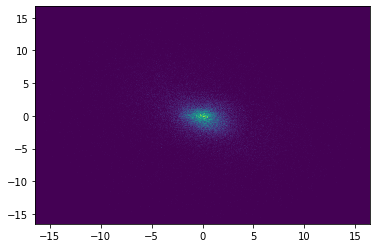

In [28]:
Mass = plt.hist2d(star_snapdict['Coordinates'][:,1],star_snapdict['Coordinates'][:,0],
                       weights=star_snapdict['Masses'], bins=pixels)

In [38]:
np.sum(star_snapdict['Masses'])

900077065.1488048

In [39]:
np.sum(Mass[0][::-1])

900077065.148805

In [40]:
pix_to_kpc = pixels / (FOV*2)

In [41]:
SigmaMass = Mass[0][::-1] * (pix_to_kpc)**2 #Convert pixel values Mass/Pix2 to Mass/Kpc2


In [42]:
np.sum(SigmaMass)*(FOV*2/pixels)**2

900077065.1488061

In [35]:
np.sum(Mass[0][::-1])

900077065.148805

In [36]:
np.sum(SigmaMass)

11112062532701.31

In [ ]:

SigmaMass = Mass[0][::-1] * (pixels / FOV*2 )**2 #Convert pixel values Mass/Pix2 to Mass/Kpc2
SigmaMass_smoothed = gaussian_filter(SigmaMass, sigma = np.median(star_snapdict['hsml'])*kpctopix )
SigmaMass_smoothed[SigmaMass_smoothed<1e6] = 1e6

Mass_image = axs[0].imshow(SigmaMass_smoothed+1 ,norm=colors.LogNorm(vmin=1e6, vmax=1e9),
                           cmap='Greys_r')






In [ ]:

#ax_sersic.set_ylim(60000, np.max(sb_light)*1.1)
#ax_sersic.set_ylabel("'den' [L$_\odot$ kpc$^{-2}$]")
#ax_sersic.set_xlabel(" Radius [kpc]")
#ax_sersic.legend(frameon=False,loc=1)
#ax_sersic.text(r[0], 56000 +  np.log10(np.max(sb_light))/10*56000*2,f'R$_e$: {popt[1]:.2f} kpc',color='k')
#ax_sersic.text(r[0], 56000 +  np.log10(np.max(sb_light))/10*56000,f'n:  {popt[2]:.2f}',color='k')
#ax_sersic.get_figure().set_dpi(120)

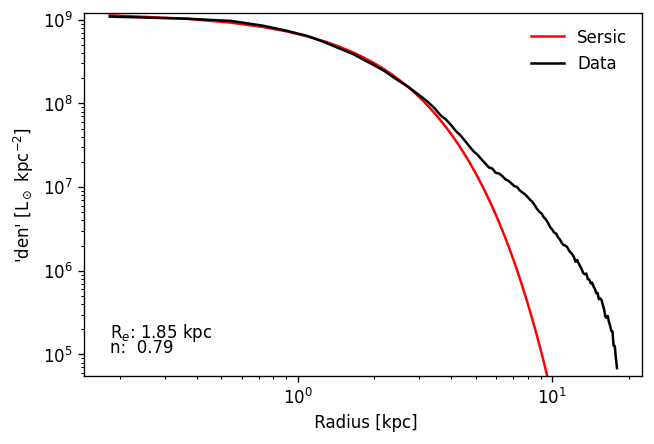

In [57]:
radius,sb = measure_surfbright(SigmaMass, FOV=FOV, nmeasure=100)
popt,std= fit_sersic(radius, sb, ax_sersic=plt.gca())


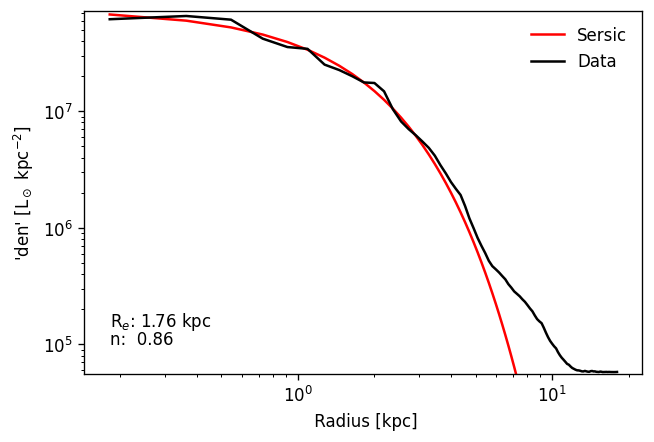

In [56]:
radius,sb = measure_surfbright(gband, FOV=FOV, nmeasure=100)
popt,std= fit_sersic(radius, sb, ax_sersic=plt.gca())


radius,sb = measure_surfbright(SigmaMass, FOV=FOV, nmeasure=100)
popt,std= fit_sersic(radius, sb, ax_sersic=plt.gca())



In [ ]:
nmeasure=m11c['sample_n'].values[0]
FOV = m11c['FOV'].values[0]

params1D_ellip = [m11c['Ie_1D_ellip'].values[0],
                  m11c['reff_1D_ellip'].values[0], 
                  m11c['n_1D_ellip'].values[0]]

params2D = [m11c['Ie_2D'].values[0],
            m11c['reff_2D'].values[0],
            m11c['n_2D'].values[0],
            m11c['x0_2D'].values[0],
            m11c['y0_2D'].values[0],
            m11c['ellip_2D'].values[0],
            m11c['theta_2D'].values[0]
           ]



r,sb = measure_surfbright(band_image, FOV, nmeasure=nmeasure, pixel=pixels, 
                          major_axis=params2D[1], ellip=params2D[5], theta=params2D[6])


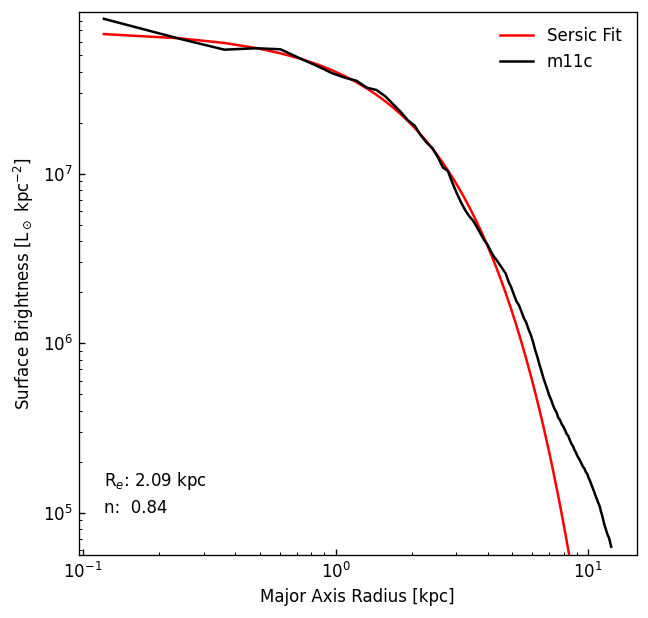

In [50]:


# 1D fit with ellipse
fig = plt.figure(figsize = (6, 6))
ax = plt.gca()

plt.tick_params(axis='both', which='both', direction='in')
ax.loglog(r, sersic(r, *params1D_ellip), label='Sersic Fit',c='red')
ax.loglog(r, sb,label='m11c',c='k')
ax.set_ylim(56000, np.max(sb)*1.1)
ax.set_ylabel("Surface Brightness [L$_\odot$ kpc$^{-2}$]")
ax.set_xlabel("Major Axis Radius [kpc]")

ax.legend(frameon=False,loc=1)
ax.text(r[0], 56000 +  np.log10(np.max(sb))/10*56000*2,f'R$_e$: {params1D_ellip[1]:.2f} kpc',color='black')
ax.text(r[0], 56000 +  np.log10(np.max(sb))/10*56000*1,f'n:  {params1D_ellip[2]:.2f}',color='black')
ax.get_figure().set_dpi(120)

#plt.savefig('../Figures/paper/sersic_ellip_fit_m11c.pdf', bbox_inches='tight', dpi=300)

plt.show()


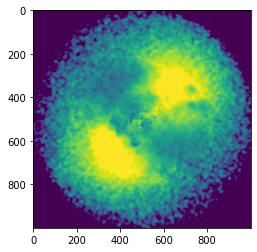

In [73]:
Mass_to_Light_ratio = (SigmaMass_smoothed+1) / (band_image+1) 
plt.imshow((Mass_to_Light_ratio),norm=colors.LogNorm(vmin=1e0, vmax=1e2))

(array([[787.,  13.,  24., ...,  31.,   0.,   0.],
        [783.,  14.,  21., ...,  31.,   0.,   0.],
        [779.,  14.,  20., ...,  31.,   0.,   0.],
        ...,
        [680.,   3.,   5., ...,  91.,   0.,   0.],
        [681.,   2.,   5., ...,  93.,   0.,   0.],
        [681.,   3.,   5., ...,  94.,   0.,   0.]]),
 array([-4.76080684, -4.03651565, -3.31222445, -2.58793326, -1.86364206,
        -1.13935087, -0.41505967,  0.30923152,  1.03352272,  1.75781392,
         2.48210511]),
 <a list of 1000 BarContainer objects>)

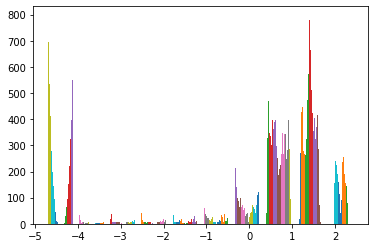

In [68]:
plt.hist(np.log10(Mass_to_Light_ratio))

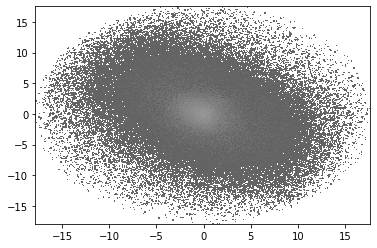

In [61]:
mass = plt.hist2d(star_snapdict['Coordinates'][:,0],star_snapdict['Coordinates'][:,1], 
           weights=star_snapdict['Masses'], bins=1000,norm=colors.LogNorm(vmin=1, vmax=1e10),
                      cmap='Greys_r')
cb = fig.colorbar(mass[3],  orientation="horizontal", pad=0.05)
cb.set_label(r'N$_{Stars}$')

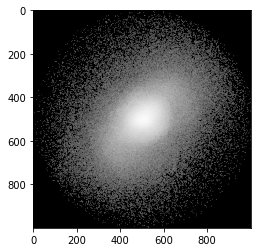

In [85]:
image = plt.imshow((SigMass + 1) / (18*2 / 1000)**2 ,norm=colors.LogNorm(vmin=1e4, vmax=1e8),
                      cmap='Greys_r')


In [80]:
np.log10(np.max((SigMass + 1) / (18*2 / 1000)**2))

8.024612358884253

In [53]:
SigMass + 1

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

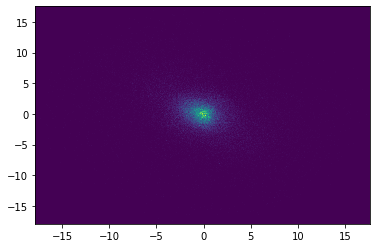

In [43]:
Mass = plt.hist2d(star_snapdict['Coordinates'][:,0],star_snapdict['Coordinates'][:,1],
                       weights=star_snapdict['Masses'], bins=pixels)

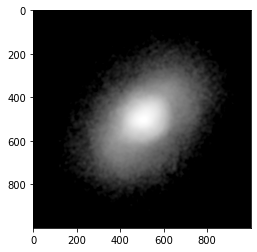

In [55]:
SigmaMass = Mass[0] * (pixels / FOV*2 )**2 #Convert pixel values Mass/Pix2 to Mass/Kpc2
SigmaMass_smoothed = gaussian_filter(SigmaMass, sigma = np.median(star_snapdict['hsml'])*kpctopix )
Mass_image = plt.gca().imshow(SigmaMass_smoothed+1 ,norm=colors.LogNorm(vmin=1e6, vmax=1e9),
                           cmap='Greys_r')

In [18]:
SigmaMass

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

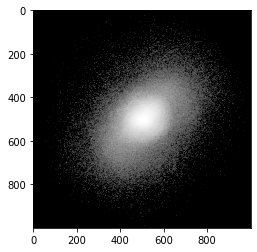

In [28]:
Mass_image = plt.imshow(SigmaMass+1 ,norm=colors.LogNorm(vmin=1e6, vmax=1e9),
                           cmap='Greys_r')

(array([[789.,  21.,  45., ...,   0.,   0.,   0.],
        [787.,  20.,  43., ...,   0.,   0.,   0.],
        [783.,  19.,  34., ...,   0.,   0.,   0.],
        ...,
        [681.,   4.,  11., ...,   0.,   0.,   0.],
        [682.,   4.,  12., ...,   0.,   0.,   0.],
        [682.,   4.,  14., ...,   0.,   0.,   0.]]),
 array([0.        , 0.90487996, 1.80975992, 2.71463988, 3.61951984,
        4.5243998 , 5.42927977, 6.33415973, 7.23903969, 8.14391965,
        9.04879961]),
 <a list of 1000 BarContainer objects>)

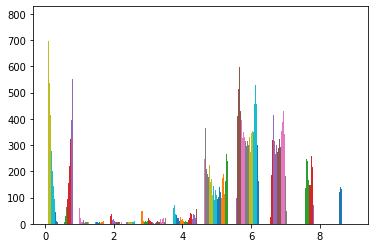

In [46]:
plt.hist(np.log10(SigmaMass_smoothed+1))

In [47]:
np.median(star_snapdict['hsml'])*kpctopix 

5.207267900307973

In [87]:
pixels = 1000 #image pixel size
FOV=limvalue
view='xy' #'yz','zx'
mock_image, uband, gband, rband = get_mock_observation(star_snapdict,gas_snapdict,
                                  FOV=FOV, 
                                  return_type='mock_image',
                                  pixels=pixels, 
                                  view=view,
                                  center='light')


Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
Projecting with attenuation...
total lum before attenuation in each band (Lsun/1e10): [0.15558315 0.09583094 0.06934586]
opacity in each band: [1585.97915621 1154.44253194  799.38644653]
total gas mass: 0.030138714882912566
maxden ==  52622824.0  dynrange ==  912.7983347788378  minden ==  57650.0
